# 2A.ml - Analyse de sentiments - correction

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) où on utilise la fonction ``load_sentiment_dataset``.

In [3]:
from ensae_teaching_cs.data import load_sentiment_dataset
df = load_sentiment_dataset()
df.head()

,sentance,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled
1,"Good case, Excellent value.",1,amazon_cells_labelled
2,Great for the jawbone.,1,amazon_cells_labelled
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled
4,The mic is great.,1,amazon_cells_labelled


## Exercice 1 : approche td-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*. On s'occupe des variables catégorielles.

### La variable catégorielle

Ce serait un peu plus simple avec le module [Category Encoders](http://contrib.scikit-learn.org/categorical-encoding/) ou la dernière nouveauté de scikit-learn : [ColumnTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer).

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                df.drop("sentiment", axis=1), df["sentiment"])

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
le.fit(X_train["source"])
X_le = le.transform(X_train["source"])
X_le.shape

(2250,)

In [6]:
X_le_mat = X_le.reshape((X_le.shape[0], 1))

In [7]:
ohe = OneHotEncoder(categories="auto")
ohe.fit(X_le_mat)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [8]:
X_le_encoded = ohe.transform(X_le_mat)
train_cat = X_le_encoded.todense()
test_cat = ohe.transform(le.transform(X_test["source"]).reshape((len(X_test), 1))).todense()

In [9]:
import pandas
X_train2 = pandas.concat([X_train.reset_index(drop=True),
                          pandas.DataFrame(train_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_train2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,It's very convenient and simple to use - gets ...,amazon_cells_labelled,1.0,0.0,0.0
1,Thoroughly disappointed!,yelp_labelled,0.0,0.0,1.0


In [10]:
X_test2 = pandas.concat([X_test.reset_index(drop=True),
                         pandas.DataFrame(test_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_test2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,This is one of the worst Sandra Bullock movie ...,imdb_labelled,0.0,1.0,0.0
1,It is indescribably the most annoying and idio...,imdb_labelled,0.0,1.0,0.0


### tokenisation

On tokenise avec le module [spacy](https://spacy.io/usage/spacy-101#annotations-token) qui requiert des données supplémentaires pour découper en mot avec ``pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz`` selon les instructions dévoilées dans le [guide de départ](https://spacy.io/usage/models) ou encore ``python -m spacy download en``. Le module [gensim](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/artificiel_tokenize.html?highlight=tokenisation#gensim) ne requiert pas d'installation. On peut aussi s'inspirer de l'example [word2vec pré-entraînés](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html#word2vec-pre-entraines).

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Ca marche après avoir installé le corpus correspondant
# python -m spacy download en_core_web_sm

In [12]:
doc = nlp(X_train2.iloc[0,0])
[token.text for token in doc]

['It',
 "'s",
 'very',
 'convenient',
 'and',
 'simple',
 'to',
 'use',
 '-',
 'gets',
 'job',
 'done',
 '&',
 'makes',
 'the',
 'car',
 'ride',
 'so',
 'much',
 'smoother',
 '.']

### tf-idf

Une fois que les mots sont tokenisé, on peut appliquer le *tf-idf*.

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
tokenizer = lambda text: [token.text.lower() for token in nlp(text)]
count = CountVectorizer(tokenizer=tokenizer, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

In [14]:
pipe.fit(X_train["sentance"])

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x00000236B063EBF8>,
                                 vocabulary=None)),
                ('tfidftransformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True))],
         verbose=False)

In [15]:
train_feature = pipe.transform(X_train2["sentance"])
train_feature

<2250x4457 sparse matrix of type '<class 'numpy.float64'>'
	with 29237 stored elements in Compressed Sparse Row format>

In [16]:
test_feature = pipe.transform(X_test2["sentance"])

### Combinaison de toutes les variables

In [17]:
train_feature.shape, train_cat.shape

((2250, 4457), (2250, 3))

In [18]:
import numpy
np_train = numpy.hstack([train_feature.todense(), train_cat])
np_test = numpy.hstack([test_feature.todense(), test_cat])

### Calage d'un modèle

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(np_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
rf.score(np_test, y_test)

0.7826666666666666

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity). Avec [spacy](https://spacy.io/usage/vectors-similarity), c'est assez simple :

In [22]:
vv = nlp(X_train2.iloc[0, 0])
list(vv)[0].vector[:10], vv.vector.shape

(array([ 2.137395  , -3.5441318 ,  1.3239388 , -0.07575727, -4.7694845 ,
        -0.23332378, -0.28352684,  0.8881438 , -5.076993  ,  6.4225345 ],
       dtype=float32), (96,))

On fait la somme.

In [23]:
sum([_.vector for _ in vv])[:10]

array([ 11.685625  , -17.955473  , -17.706102  , -31.118076  ,
       -13.125497  ,  45.72329   ,  13.193462  ,  -0.44241935,
         1.4067612 ,  14.676732  ], dtype=float32)

In [24]:
np_train_vect = numpy.zeros((X_train2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_train2["sentance"]):
    np_train_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [25]:
np_test_vect = numpy.zeros((X_test2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_test2["sentance"]):
    np_test_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [26]:
np_train_v = numpy.hstack([np_train_vect, train_cat])
np_test_v = numpy.hstack([np_test_vect, test_cat])

In [27]:
rfv = RandomForestClassifier(n_estimators=50)
rfv.fit(np_train_v, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
rfv.score(np_test_v, y_test)

0.6053333333333333

Moins bien...

## Exercice 3 : comparer les deux approches

Avec une courbe [ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) par exemple.

In [29]:
pmodel1 = rf.predict_proba(np_test)[:, 1]
pmodel2 = rfv.predict_proba(np_test_v)[:, 1]

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr1, tpr1, th1 = roc_curve(y_test, pmodel1)
fpr2, tpr2, th2 = roc_curve(y_test, pmodel2)

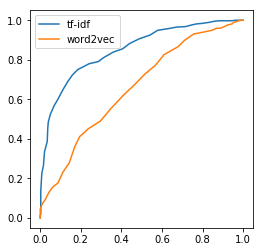

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr1, tpr1, label='tf-idf')
ax.plot(fpr2, tpr2, label='word2vec')
ax.legend();

## Petite analyse d'erreurs

On combine les erreurs des modèles sur la base de test.

In [32]:
final = X_test.copy()
final["model1"] = pmodel1
final["model2"] = pmodel2
final["label"] = y_test
final.head()

,sentance,source,model1,model2,label
908,This is one of the worst Sandra Bullock movie ...,imdb_labelled,0.20,0.46,0
514,It is indescribably the most annoying and idio...,imdb_labelled,0.52,0.56,0
957,The real disappointment was our waiter.,yelp_labelled,0.32,0.58,0
230,"However, I recently watched the whole thing ag...",imdb_labelled,0.50,0.56,0
359,The things that the four kids get themselves i...,imdb_labelled,0.54,0.60,1


On regarde des erreurs.

In [33]:
erreurs = final[final["label"] == 1].sort_values("model2")
erreurs.head()

,sentance,source,model1,model2,label
937,"They are so easy to love, but even more easy t...",imdb_labelled,0.72,0.12,1
676,I can't wait to go back.,yelp_labelled,0.42,0.16,1
414,I would have casted her in that role after rea...,imdb_labelled,0.40,0.18,1
369,I was looking for this headset for a long time...,amazon_cells_labelled,0.30,0.20,1
632,I did not have any problem with this item and ...,amazon_cells_labelled,0.28,0.22,1


In [34]:
list(erreurs["sentance"])[:5]

['They are so easy to love, but even more easy to identify with.  ',
 "I can't wait to go back.",
 'I would have casted her in that role after ready the script.  ',
 "I was looking for this headset for a long time and now that I've got it I couldn't be happier.",
 'I did not have any problem with this item and would order it again if needed.']

Le modèle 2 reconnaît mal les négations visiblement. On regarde le modèle 1.

In [35]:
erreurs = final[final["label"] == 1].sort_values("model1")
erreurs.head()

,sentance,source,model1,model2,label
436,"The soundtrack wasn't terrible, either.",imdb_labelled,0.10,0.44,1
574,"I've had no trouble accessing the Internet, do...",amazon_cells_labelled,0.16,0.62,1
604,Couldn't ask for a more satisfying meal.,yelp_labelled,0.18,0.22,1
126,I liked this movie way too much.,imdb_labelled,0.18,0.44,1
317,This is definitely a must have if your state d...,amazon_cells_labelled,0.20,0.42,1


In [36]:
list(erreurs["sentance"])[:5]

["The soundtrack wasn't terrible, either.  ",
 "I've had no trouble accessing the Internet, downloading ringtones or performing any of the functions.",
 "Couldn't ask for a more satisfying meal.",
 'I liked this movie way too much.  ',
 'This is definitely a must have if your state does not allow cell phone usage while driving.']

Idem, voyons là où les modèles sont en désaccords.

In [37]:
final["diff"] = final.model1 - final.model2

In [38]:
erreurs = final[final["label"] == 1].sort_values("diff")
erreurs.head()

,sentance,source,model1,model2,label,diff
574,"I've had no trouble accessing the Internet, do...",amazon_cells_labelled,0.16,0.62,1,-0.46
888,Seriously killer hot chai latte.,yelp_labelled,0.44,0.80,1,-0.36
789,This is an extraordinary film.,imdb_labelled,0.58,0.94,1,-0.36
791,This film highlights the fundamental flaws of ...,imdb_labelled,0.34,0.68,1,-0.34
436,"The soundtrack wasn't terrible, either.",imdb_labelled,0.10,0.44,1,-0.34


In [39]:
erreurs.tail()

,sentance,source,model1,model2,label,diff
817,You will leave the theater wanting to go out a...,imdb_labelled,0.68,0.24,1,0.44
389,The company shipped my product very promptly a...,amazon_cells_labelled,0.94,0.48,1,0.46
869,"Just really good.. So far, probably the best B...",amazon_cells_labelled,0.74,0.26,1,0.48
80,I wear it everyday and it holds up very well.,amazon_cells_labelled,0.84,0.32,1,0.52
937,"They are so easy to love, but even more easy t...",imdb_labelled,0.72,0.12,1,0.60


Le modèle 2 (word2vec) a l'air meilleur sur les phrases longues, le modèle 1 (tf-idf) saisit mieux les mots positifs. A confirmer sur plus de données. 

* Enlever les stop words, les signes de ponctuation.
* Combiner les deux approches.
* n-grammes
* ...

Dernière analyse en regardant le taux d'erreur par source.

In [40]:
r1 = rf.predict(np_test)
r2 = rfv.predict(np_test_v)
final["rep1"] = r1
final["rep2"] = r2
final["err1"] = (final.label - final.rep1).abs()
final["err2"] = (final.label - final.rep2).abs()
final["total"] = 1
final.head()

,sentance,source,model1,model2,label,diff,rep1,rep2,err1,err2,total
908,This is one of the worst Sandra Bullock movie ...,imdb_labelled,0.20,0.46,0,-0.26,0,0,0,0,1
514,It is indescribably the most annoying and idio...,imdb_labelled,0.52,0.56,0,-0.04,1,1,1,1,1
957,The real disappointment was our waiter.,yelp_labelled,0.32,0.58,0,-0.26,0,1,0,1,1
230,"However, I recently watched the whole thing ag...",imdb_labelled,0.50,0.56,0,-0.06,0,1,0,1,1
359,The things that the four kids get themselves i...,imdb_labelled,0.54,0.60,1,-0.06,1,1,0,0,1


In [41]:
final[["source", "err1", "err2", "total"]].groupby("source").sum()

,err1,err2,total
source,,,
amazon_cells_labelled,59,95,234
imdb_labelled,60,102,258
yelp_labelled,44,99,258


*imdb* paraît une source une peu plus difficile à saisir. Quoiqu'il en soit, 2000 phrases pour apprendre est assez peu pour apprendre.

## Versions utilisées pour ce notebook

[spacy](https://spacy.io/) s'est montré quelque peu fantasques cette année avec quelques erreurs notamment celle-ci :
[ValueError: cymem.cymem.Pool has the wrong size, try recompiling](https://github.com/explosion/spaCy/issues/2852). Voici les versions utilisées...

In [42]:
def version(module, sub=True):
    try:
        ver = getattr(module, '__version__', None)
        if ver is None:
            ver = [_ for _ in os.listdir(os.path.join(module.__file__, '..', '..' if sub else '')) \
                   if module.__name__ in _ and 'dist' in _][-1]
        return ver
    except Exception as e:
        return str(e)

In [43]:
import os
import thinc
print("thinc", version(thinc))
import preshed
print("preshed", version(preshed))
import cymem
print("cymem", version(cymem))
import murmurhash
print("murmurhash", version(murmurhash))
import plac
print("plac", plac.__version__)
import spacy
print("spacy", spacy.__version__)

import msgpack
print("msgpack", version(msgpack))
import numpy
print("numpy", numpy.__version__)

thinc 7.0.4
preshed preshed-2.0.1.dist-info
cymem cymem-2.0.2.dist-info
murmurhash murmurhash-1.0.2.dist-info
plac 0.9.6
spacy 2.1.4
msgpack msgpack-0.6.1.dist-info
numpy 1.16.2
